In [45]:
from pathlib import Path
from collections import defaultdict
import datetime as dt

import numpy as np
from matplotlib import pyplot as plt
from astropy.timeseries import LombScargle
import emd
from scipy.signal import welch, find_peaks
from scipy.interpolate import interp1d

from rstn_parse.parsers import load_collected_data, STATIONS, RSTN_FREQS_MHZ
from rstn_parse.analysis.solar_cycle_indices import get_international_daily_ssn
from rstn_parse.analysis.f107 import F107

from rao_parse.parsers import SP2_24DailyReader

from norp_parse.parsers import load_norp_station_avg_daily_data

In [46]:
RSTN_DATA_PATH = Path('/home/artem/Data/rstn_noonflux_table.dat')
RAO_SP2_24_DATA_PATH = Path('/home/artem/Data/RAO/SP2_24')
NORP_DAILY_DATA_PATH = Path('/home/artem/Data/NoRP/daily')

In [47]:
sun_period_days = 27
sun_frequency = 1 / sun_period_days
print(f'Frequency of 27 day period: {sun_frequency:.3f} 1/day')
F107_FREQ_MHZ = 2800

Frequency of 27 day period: 0.037 1/day


In [185]:
def weighted_nanmean(x, weights, axis=0):
    x = np.asarray(x)
    weights = np.asarray(x)
    weights[np.isnan(x)] = np.nan
    return np.nansum(x * weights, axis=axis) / np.nansum(weights, axis=axis)

## Data preparation

In [49]:
data = load_collected_data(RSTN_DATA_PATH)
f107 = F107()
ssn_data = get_international_daily_ssn()
norp_data = load_norp_station_avg_daily_data(NORP_DAILY_DATA_PATH)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20350 entries, 1966-05-01 to 2023-07-01
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (LEAR, 245)    11075 non-null  float64
 1   (LEAR, 410)    11195 non-null  float64
 2   (LEAR, 610)    11241 non-null  float64
 3   (LEAR, 1415)   11360 non-null  float64
 4   (LEAR, 2695)   11808 non-null  float64
 5   (LEAR, 4995)   11493 non-null  float64
 6   (LEAR, 8800)   11873 non-null  float64
 7   (LEAR, 15400)  11581 non-null  float64
 8   (PALE, 245)    10356 non-null  float64
 9   (PALE, 410)    10555 non-null  float64
 10  (PALE, 610)    10645 non-null  float64
 11  (PALE, 1415)   11705 non-null  float64
 12  (PALE, 2695)   11700 non-null  float64
 13  (PALE, 4995)   11540 non-null  float64
 14  (PALE, 8800)   11679 non-null  float64
 15  (PALE, 15400)  11042 non-null  float64
 16  (SGMR, 245)    17084 non-null  float64
 17  (SGMR, 410)    16835 non-null  fl

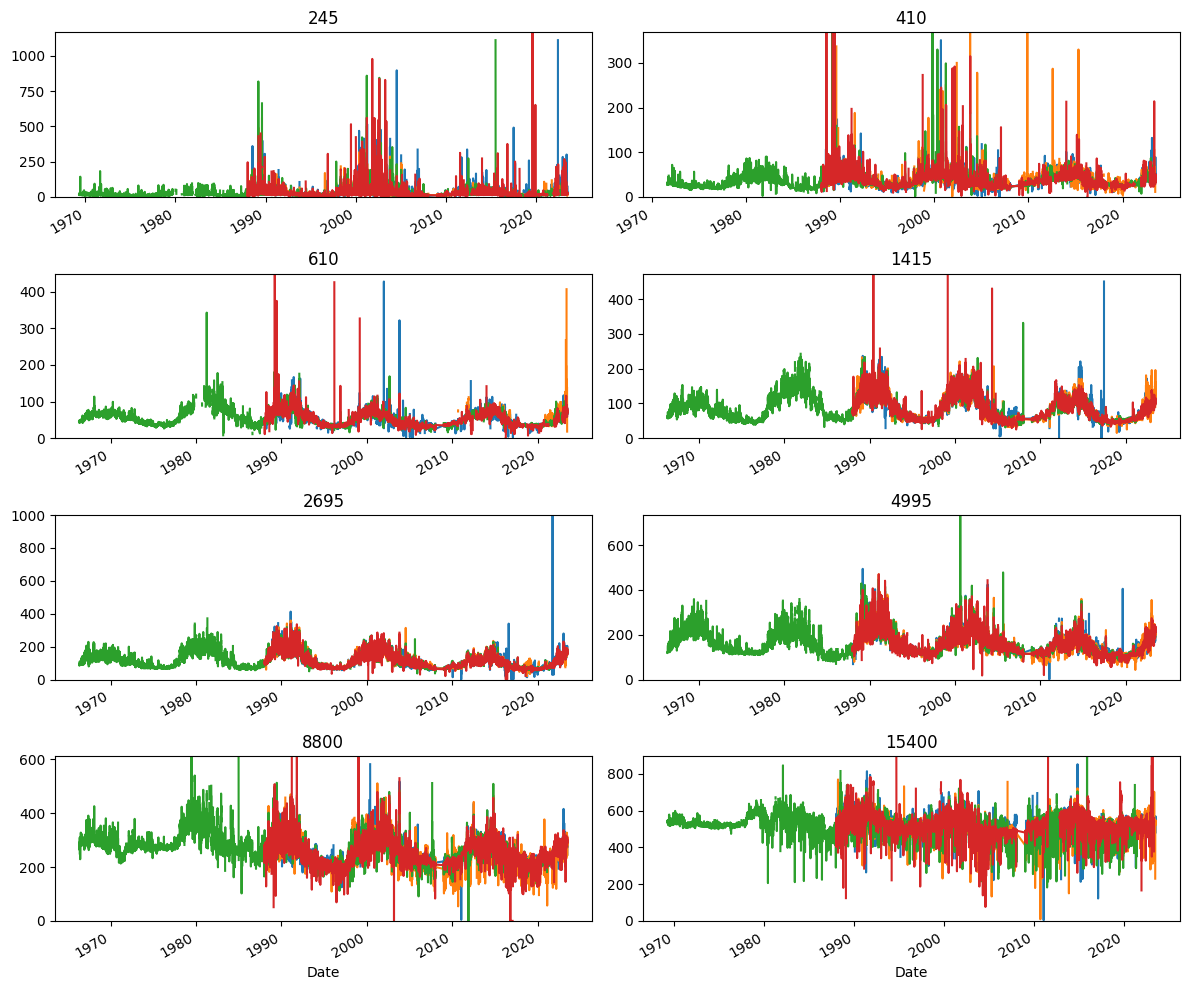

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
for station in STATIONS:
    for ax, freq in zip(axes.ravel(), RSTN_FREQS_MHZ):
        data[station, str(freq)].plot(ax=ax)
        ax.set_title(freq)
        if freq != 2695:
            ax.set_ylim(0, None)
        else:
            ax.set_ylim(0, 1000)
        ax.set_xlabel('')
    axes.ravel()[-2].set_xlabel('Date')
    axes.ravel()[-1].set_xlabel('Date')
plt.tight_layout()

In [52]:
dates = np.array([date.date() for date in data.index.to_pydatetime()], dtype=dt.date)

In [70]:
f107_flux = f107.mean_daily(f107.dates)

/mnt/disk2/artem/projects/rstn_parse/rstn_parse/analysis/f107.py:77: RuntimeWarning: Mean of empty slice
  flux[i] = np.nanmean(self.flux[self.dates == date])


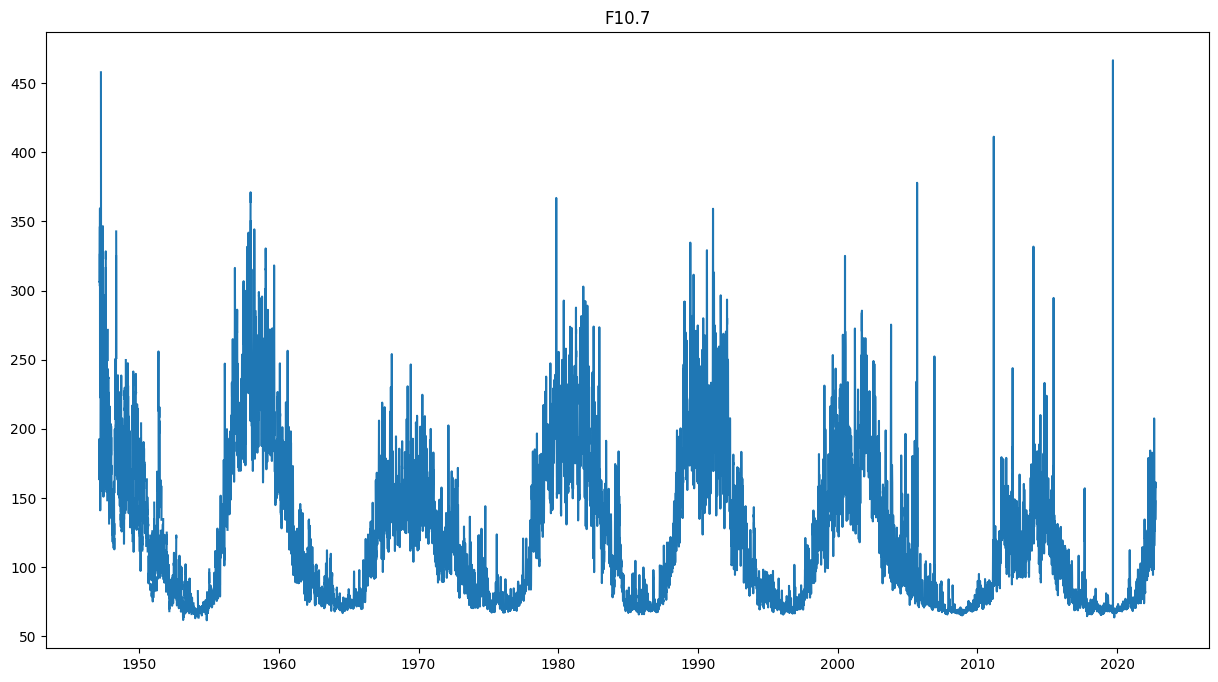

In [72]:
plt.figure(figsize=(15, 8))
plt.plot(f107.dates, f107_flux)
plt.title('F10.7');

In [73]:
def filtered_mean(x, freq):
    limit = {245: 200, 410: 200, 610: 200, 1415: 300, 2695: 500, 4995: 600, 8800: 700, 15400: 900}[freq]
    x[x > limit] = np.nan
    return np.nanmean(x, axis=1)

In [74]:
network_averaged_flux = {}
for freq in RSTN_FREQS_MHZ:
    freq_df = data.loc[:, (slice(None), str(freq))]
#     network_averaged_flux[freq] = freq_df.mean(axis=1).values
    network_averaged_flux[freq] = filtered_mean(freq_df.values, freq)

/tmp/ipykernel_56574/3230591502.py:4: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=1)


In [75]:
def get_window_trend(arr, window):
    left = window // 2
    right = (window - 1) // 2
    return np.nanmedian(
        np.lib.stride_tricks.sliding_window_view(
            np.pad(arr, (left, right), constant_values=np.nan), window
        ),
        axis=1
    )

In [76]:
network_averaged_flux_trends_90 = {freq: get_window_trend(arr, 90) 
                                   for freq, arr in network_averaged_flux.items()}
network_averaged_flux_trends_360 = {freq: get_window_trend(arr, 360) 
                                    for freq, arr in network_averaged_flux.items()}

/home/artem/py_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [77]:
f107_flux_trend_90 = get_window_trend(f107_flux, 90)
f107_flux_trend_360 = get_window_trend(f107_flux, 360)

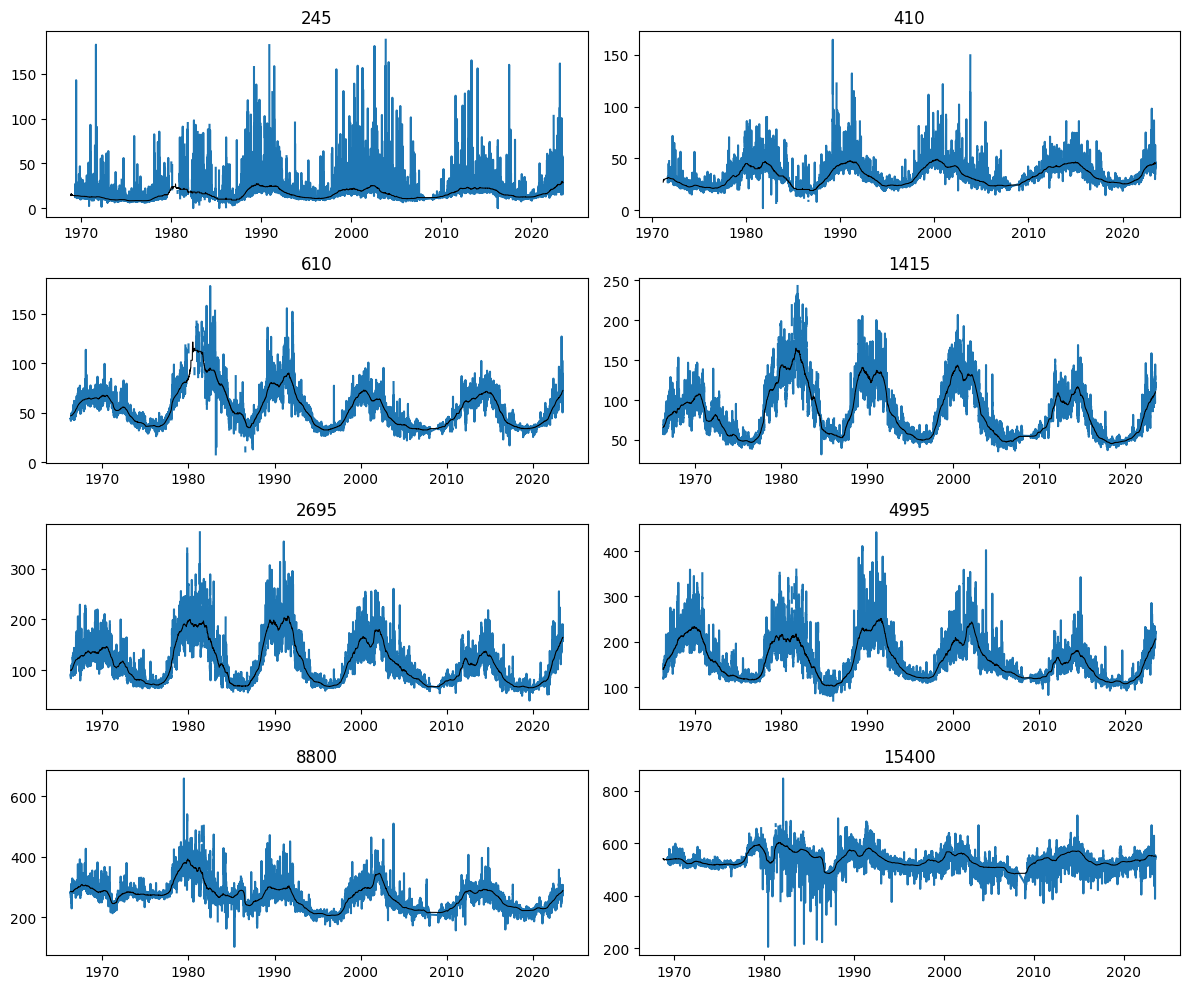

In [78]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
for ax, freq in zip(axes.ravel(), sorted(network_averaged_flux)):
    flux = network_averaged_flux[freq]
    trend = network_averaged_flux_trends_360[freq]
    ax.plot(dates, flux)
    ax.plot(dates, trend, color='k', lw=0.75)
    ax.set_title(freq)
plt.tight_layout()

In [573]:
def to_doy(date_arr):
    return np.array([date.timetuple().tm_yday for date in date_arr])

def to_days_2000(date_arr):
    return np.array([td.days for td in date_arr - dt.date(2000, 1, 1)])

days_2000 = to_days_2000(dates)
days_2000_f107 = to_days_2000(f107.dates)
days_2000_norp = to_days_2000(np.array([d.date() for d in norp_data.index.to_pydatetime()], dtype=dt.date))

## RAO data

In [574]:
rao_sp2_24_reader = SP2_24DailyReader(RAO_SP2_24_DATA_PATH)

In [575]:
res = rao_sp2_24_reader.get_daily_data(dt.date(2021, 1, 1))

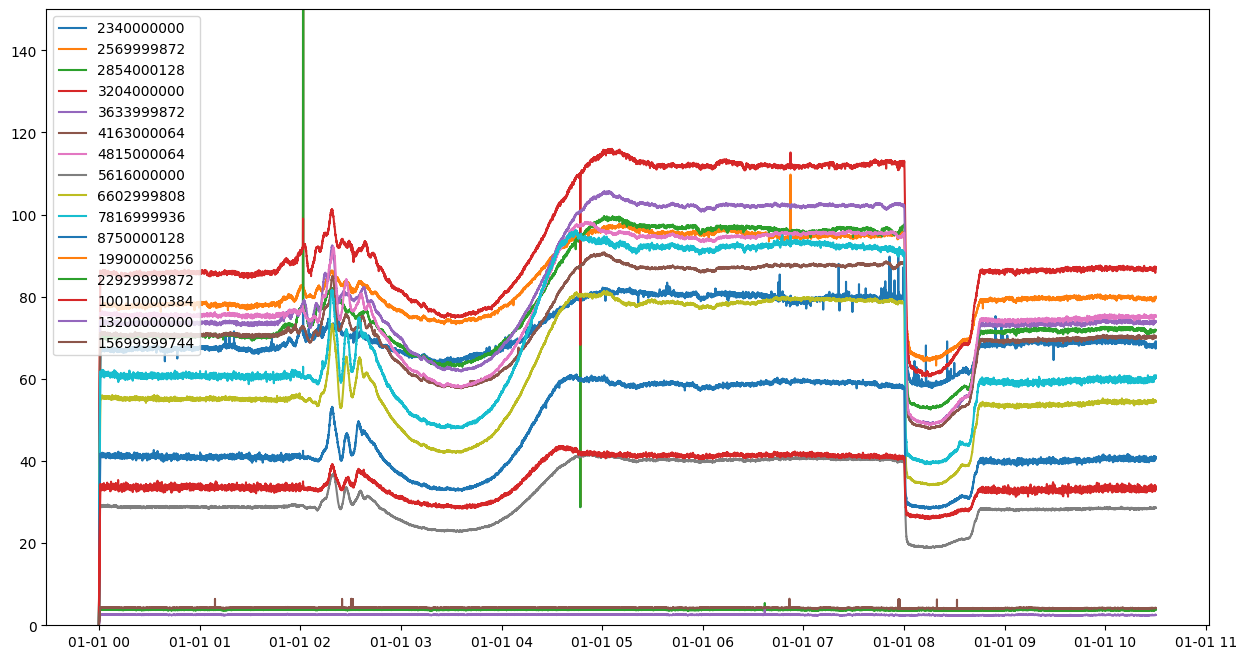

In [576]:
plt.figure(figsize=(15, 8))
for freq, record in res.items():
    plt.plot(record.time_marks, record.flux, label=f'{freq}')

plt.ylim(0, 150)
plt.legend();

**Conclusion:** pronounced intrumental daily variation. Data is not used further on.

## Overall data Lomb-Scargle

In [584]:
all_titles = {}
all_days_2000 = {}
all_flux = {}
all_flux_trend_90 = {}
all_flux_trend_360 = {}

for freq in RSTN_FREQS_MHZ:
    all_titles[freq] = 'RSTN'
    all_days_2000[freq] = days_2000
    all_flux[freq] = network_averaged_flux[freq]
    all_flux_trend_90[freq] = network_averaged_flux_trends_90[freq]
    all_flux_trend_360[freq] = network_averaged_flux_trends_360[freq]

all_titles[F107_FREQ_MHZ] = 'F10.7'
all_days_2000[F107_FREQ_MHZ] = days_2000_f107
all_flux[F107_FREQ_MHZ] = f107_flux
all_flux_trend_90[F107_FREQ_MHZ] = f107_flux_trend_90
all_flux_trend_360[F107_FREQ_MHZ] = f107_flux_trend_360

for freq in norp_data.columns:
    all_titles[freq] = 'NoRP'
    all_days_2000[freq] = days_2000_norp
    all_flux[freq] = norp_data[freq].values
    all_flux_trend_90[freq] = get_window_trend(all_flux[freq], 90)
    all_flux_trend_360[freq] = get_window_trend(all_flux[freq], 360)

/home/artem/py_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [585]:
def apply_lombscargle(days_2000, flux, trend=0.0, freqs=None, fit_mean=True, min_freq=None, max_freq=None):
    m = ~np.isnan(flux)
    
    if m.sum() == 0:
        return None
    
    days_2000 = days_2000[m]
    flux = flux[m]
    trend = trend[m] if isinstance(trend, np.ndarray) else trend
    
    ls = LombScargle(days_2000, flux - trend, fit_mean=fit_mean)
    if freqs is None:
        return ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    else:
        return ls.power(freqs)

In [592]:
def plot_cycle(ax, freq, days_2000, flux, trend90, trend360, title, ylim=(0, 0.02)):
    for trend_name, trend in zip([90, 360], [trend90, trend360]):
        f, p = apply_lombscargle(days_2000, flux, trend, fit_mean=False, min_freq=0.0, max_freq=0.2)        
        ax.plot(f, p, label=f'{trend_name}d')
    
    ax.legend(loc='upper right', title='Trend')
    ax.axvline(sun_frequency, color='k')
    ax.set_title(title)
    ax.set_ylim(*ylim)
    ax.set_xlim(0.0, 0.1);

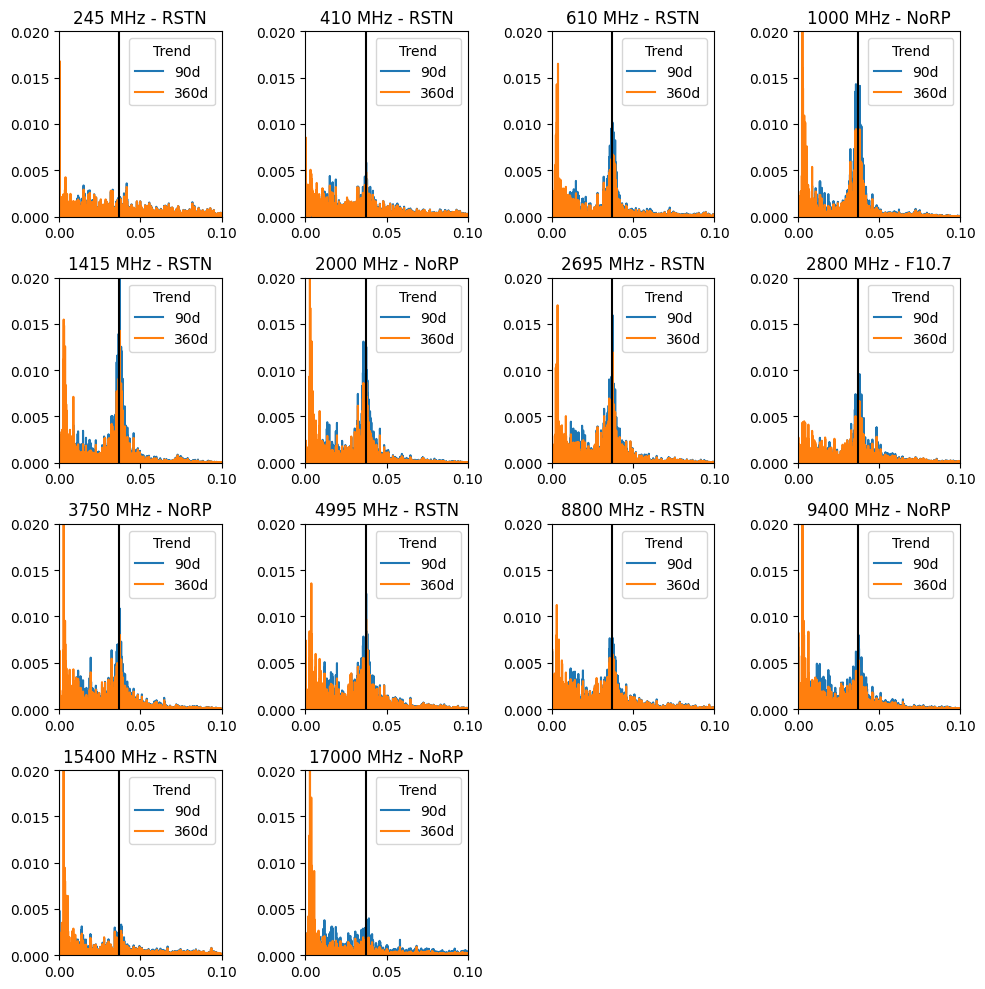

In [593]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, freq in zip(axes.ravel(), sorted(all_flux)):
    plot_cycle(ax, freq, 
               all_days_2000[freq],
               all_flux[freq],
               all_flux_trend_90[freq],
               all_flux_trend_360[freq],
               title=f'{freq} MHz - {all_titles[freq]}')
axes[-1][-2].remove()
axes[-1][-1].remove()
plt.tight_layout();

## Yearly average

In [659]:
lombscargle_yearly_freqs = np.linspace(0.002, 0.5, 4096)
rstn_bad_years = [1980, 2008]

In [660]:
def get_yearly_lombscargle(dates, flux, bad_years=None):
    doys = to_doy(dates)
    
    unique_years = np.unique([date.year for date in dates])
    dates_years = np.array([date.year for date in dates])
    
    lombscargle_yearly = []
    yearly_counts = []
    
    if bad_years is not None:
        unique_years = unique_years[~np.isin(unique_years, bad_years)]
    
    for year in unique_years:
        mask = dates_years == year
        doy_year = doys[mask]
        flux_masked = flux[mask]

        lombscargle_yearly.append(apply_lombscargle(doy_year, flux_masked, get_window_trend(flux_masked, 90), fit_mean=True, 
                                                    freqs=lombscargle_yearly_freqs))
        yearly_counts.append((~np.isnan(flux_masked)).sum())
    return unique_years, lombscargle_yearly, yearly_counts

In [661]:
rstn_unique_years = None
rstn_lombscargle_yearly = {}
rstn_yearly_counts = {}

for freq in RSTN_FREQS_MHZ:
    res = get_yearly_lombscargle(dates, network_averaged_flux[freq], bad_years=rstn_bad_years)
    rstn_unique_years, rstn_lombscargle_yearly[freq], rstn_yearly_counts[freq] = res

In [662]:
f107_unique_years, f107_lombscargle_yearly, f107_yearly_counts = get_yearly_lombscargle(f107.dates, f107_flux)

In [663]:
norp_unique_years = None
norp_lombscargle_yearly = {}
norp_yearly_counts = {}
for freq in norp_data.columns:
    res = get_yearly_lombscargle(norp_data.index.to_pydatetime(), norp_data[freq])
    norp_unique_years, norp_lombscargle_yearly[freq], norp_yearly_counts[freq] = res

In [664]:
norp_data.columns

Index([1000, 2000, 3750, 9400, 17000], dtype='int64')

In [665]:
all_unique_years = {}
all_yearly_counts = {}
all_lombscargle_yearly = {}


for freq in RSTN_FREQS_MHZ:
    all_unique_years[freq] = rstn_unique_years
    all_yearly_counts[freq] = rstn_yearly_counts[freq]
    all_lombscargle_yearly[freq] = rstn_lombscargle_yearly[freq]
        
all_unique_years[F107_FREQ_MHZ] = f107_unique_years
all_yearly_counts[F107_FREQ_MHZ] = f107_yearly_counts
all_lombscargle_yearly[F107_FREQ_MHZ] = f107_lombscargle_yearly


for freq in norp_data.columns:
    all_unique_years[freq] = norp_unique_years
    all_yearly_counts[freq] = norp_yearly_counts[freq]
    all_lombscargle_yearly[freq] = norp_lombscargle_yearly[freq]

In [666]:
len(all_yearly_counts)

14

### Number of valid measurements for each frequency

In [667]:
freq

17000

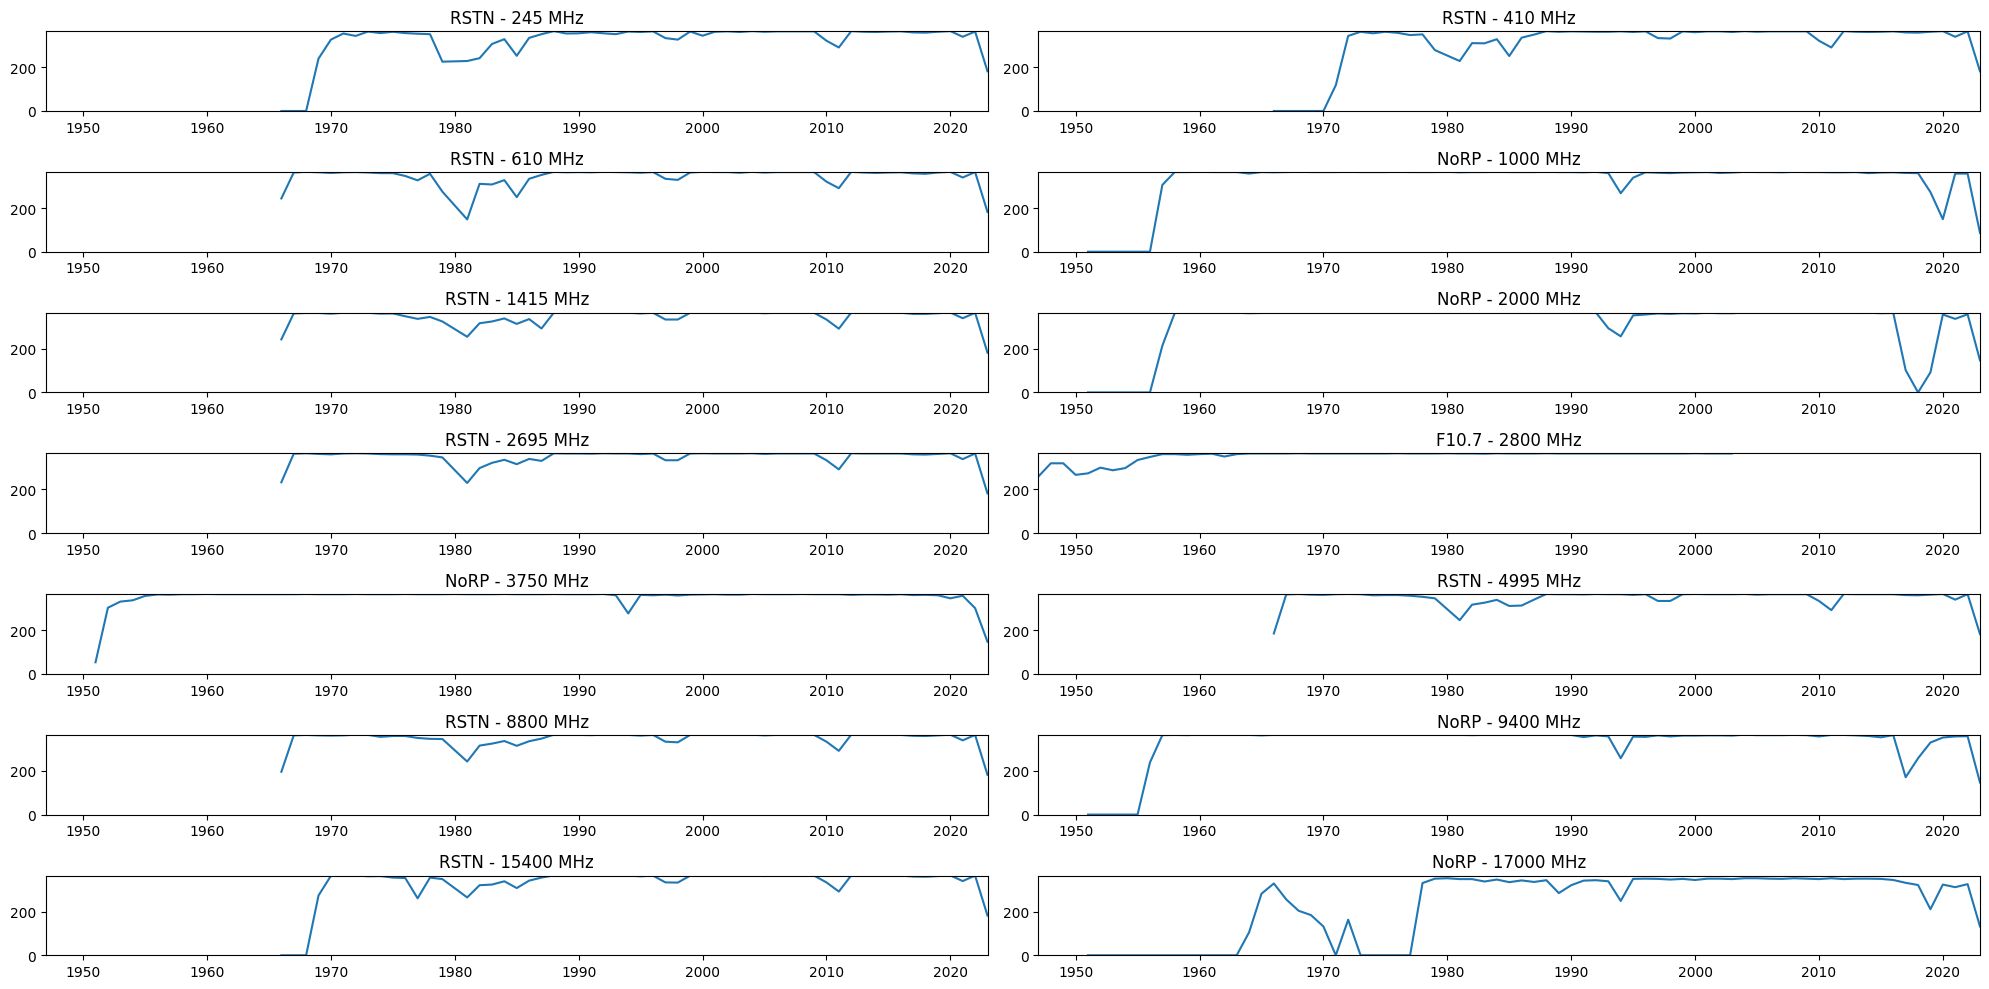

In [668]:
fig, axes = plt.subplots(7, 2, figsize=(20, 10))
unique_years_min = min(arr[0] for arr in all_unique_years.values())
unique_years_max = max(arr[-1] for arr in all_unique_years.values())

for ax, freq in zip(axes.ravel(), sorted(all_yearly_counts)):
    title = all_titles[freq]
    unique_years = all_unique_years[freq]
    counts = all_yearly_counts[freq]
    
    ax.plot(unique_years, counts)
        
    ax.set_title(f'{title} - {freq} MHz')
    ax.set_ylim(0, 365)
    ax.set_xlim(unique_years_min, unique_years_max)
plt.tight_layout()

## Lomb-Scargle

In [669]:
ssn_dates_years = np.array([date.year for date in ssn_data.date])
ssn_unique_years = np.unique(ssn_dates_years)
ssn_yearly_average = {}
for year in ssn_unique_years:
    mask = (ssn_dates_years == year) & (ssn_data.ssn != -1)
    ssn_yearly_average[year] = np.nanmean(ssn_data.ssn[mask])

In [674]:
HIGH_ACTIVITY_SSN = 50

def get_27day_peak_value(freqs, values):
    peaks_idxs = find_peaks(values)[0]
    peaks_freqs = freqs[peaks_idxs]
    peaks = values[peaks_idxs]
    
    if peaks.size > 0:
        special_peak = peaks[np.abs(peaks_freqs - sun_frequency).argmin()]
    else:
        special_peak = np.nan
    return peaks_freqs, peaks, special_peak


def _plot_ls(ax, freq, years, ls_list, ylim=(0.0, 0.3)):
    ps = []
    ws = []  # weights
    for year, ls_out in zip(years, ls_list):
        ax.plot(lombscargle_yearly_freqs, ls_out, lw=0.3)
        ps.append(ls_out)
        ws.append(ssn_yearly_average[year])

    ps = np.array(ps)
    ws = np.array(ws)

    mean_ps = np.nanmean(ps, axis=0)
    ax.plot(lombscargle_yearly_freqs, mean_ps, color='k', label='Simple')

    peaks_freqs, peaks, peak27 = get_27day_peak_value(lombscargle_yearly_freqs, mean_ps)
#     ax.scatter(peaks_freqs, peaks, color='b', zorder=10)

    peak27_energy = peak27 / mean_ps.sum()

    ps_high_activity = ps.copy()
    ps_high_activity[ws < HIGH_ACTIVITY_SSN] = np.nan

    ps_low_activity = ps.copy()
    ps_low_activity[ws >= HIGH_ACTIVITY_SSN] = np.nan

    mean_ps_high_activity = np.nanmean(ps_high_activity, axis=0)
    ax.plot(lombscargle_yearly_freqs, mean_ps_high_activity, ls=':', color='k', label='High activity')
    _, _, peak27 = get_27day_peak_value(lombscargle_yearly_freqs, mean_ps_high_activity)
    peak27_energy_high_activity = peak27 / mean_ps_high_activity.sum()

    mean_ps_low_activity = np.nanmean(ps_low_activity, axis=0)
    ax.plot(lombscargle_yearly_freqs, np.nanmean(ps_low_activity, axis=0), ls='-.', color='k',
            label='Low activity')
    _, _, peak27 = get_27day_peak_value(lombscargle_yearly_freqs, mean_ps_low_activity)
    peak27_energy_low_activity = peak27 / mean_ps_low_activity.sum()

    ax.axvline(sun_frequency, color='k')
    ax.set_title(f'{freq} MHz')
    ax.set_xlim(0, 0.1)
#     ax.legend(loc='upper right', title='Mean')
    ax.set_ylim(ylim)
    return peak27_energy, peak27_energy_high_activity, peak27_energy_low_activity


def plot_yearly_lombscargle(unique_years, lombscargle_dict, titles_dict):
    fig, axes = plt.subplots(5, 4, figsize=(10, 10))
    peak27_energy = []
    peak27_energy_high_activity = []
    peak27_energy_low_activity = []
    
    peak_markers = []
    markers = {'RSTN': 'x', 'F10.7': '^', 'NoRP': 'o'}
    
    freqs = sorted(lombscargle_dict)
    
    for ax, freq in zip(axes[0:4].ravel(), freqs):
        year_list = []
        ls_list = []
        for year, ls_out in zip(unique_years[freq], lombscargle_dict[freq]):
            if ls_out is None:
                continue
            year_list.append(year)
            ls_list.append(ls_out)
            
        ylim = (0.0, 0.3) if freq != 245 else (0.0, 0.1)
        pe, pe_high, pe_low = _plot_ls(ax, freq, year_list, ls_list, ylim=ylim)
        ax.set_yticks([])
        peak27_energy.append(pe)
        peak27_energy_high_activity.append(pe_high)
        peak27_energy_low_activity.append(pe_low)
        peak_markers.append(markers[titles_dict[freq]])

    # Spectrum
    for ax in axes[4]:
        ax.remove()
    axes[3][-2].remove()
    axes[3][-1].remove()
    
    peak_ylim = (0, 0.01)
    
    ax = plt.subplot(5, 2, 8)
    for freq, peak, marker in zip(freqs, peak27_energy, peak_markers):
        ax.scatter(freq, peak, marker=marker, color='k')
    ax.set_xlim(0, 20000)
    ax.set_ylim(*peak_ylim)
    ax.set_title('Peak amplitude')
    ax.set_xlabel('Frequency, MHz')
    
    ax = plt.subplot(5, 2, 9)
    for freq, peak, marker in zip(freqs, peak27_energy_low_activity, peak_markers):
        ax.scatter(freq, peak, marker=marker, color='k')
    ax.set_xlim(0, 20000)
    ax.set_ylim(*peak_ylim)
    ax.set_title(f'Peak amplitude (SSN < {HIGH_ACTIVITY_SSN})')
    ax.set_xlabel('Frequency, MHz')
    
    ax = plt.subplot(5, 2, 10)
    for freq, peak, marker in zip(freqs, peak27_energy_high_activity, peak_markers):
        ax.scatter(freq, peak, marker=marker, color='k')
    ax.set_xlim(0, 20000)
    ax.set_ylim(*peak_ylim)
    ax.set_title(f'Peak amplitude (SSN > {HIGH_ACTIVITY_SSN})')
    ax.set_xlabel('Frequency, MHz')
    
    plt.tight_layout()

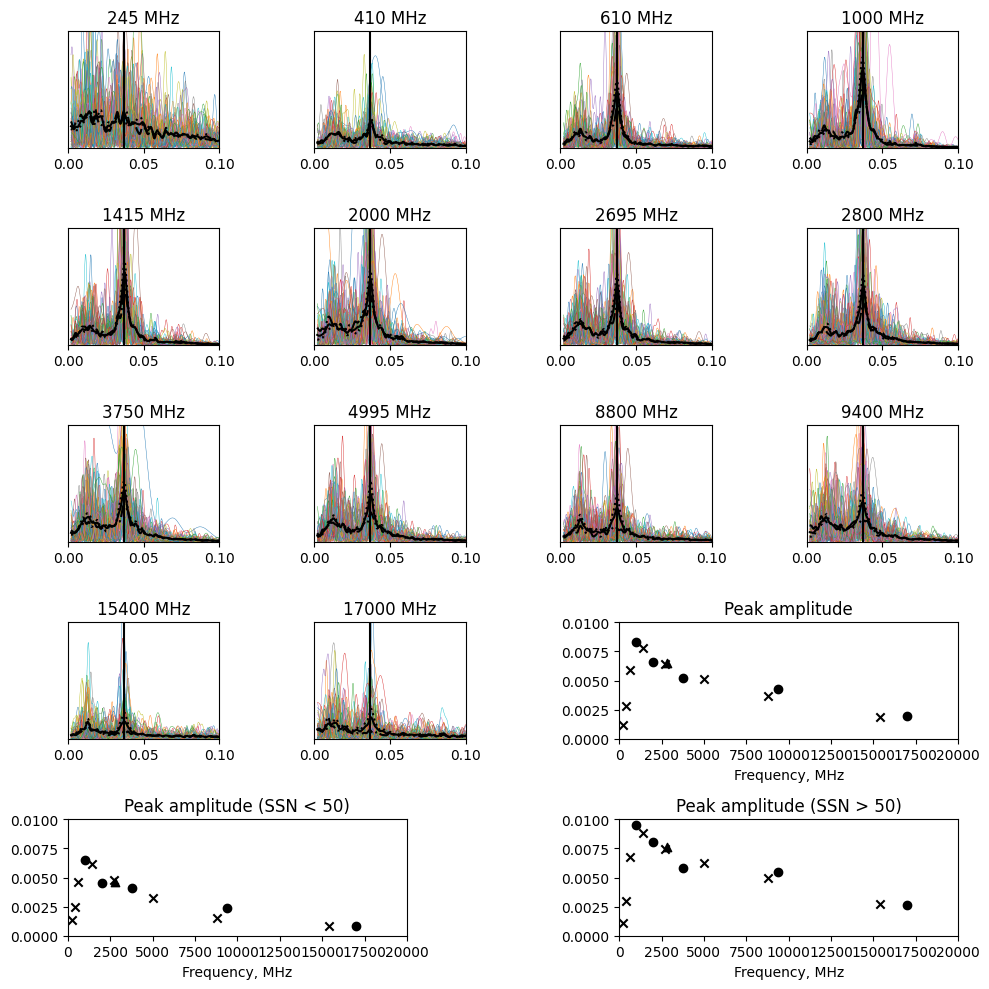

In [675]:
plot_yearly_lombscargle(all_unique_years, all_lombscargle_yearly, all_titles)

**Conclusions:**
1. 27 day period is clearly visible in 410 to 8800 MHz frequency range. It somewhat visible in 15400 MHz data but is lost in 245 MHz data.
2. Peak is between 26 and 27 day period.
3. Some years have significant mode, while others are not. High solar activity shows higher amplitude of 27-mode than total average. Low solar activity shows lower amplitude of 27-mode. Amplitude of mode near 0 shows opposite behaviour.
4. Frequency with highest amplitude is 1415 MHz.
5. First peak after zero has amplitude same as 27day period mode and present at all frequencies except 15400 (might me annual, half-annual modes).

**Suggestions:**
1. Extract amplitude of 27-mode and 0-mode. Compare for high/low solar activity (one 1D plots).

In [628]:
rstn_yearly_counts.keys()

dict_keys([245, 410, 610, 1415, 2695, 4995, 8800, 15400])

In [472]:
x = network_averaged_flux[1415].copy()
mask = np.isnan(x)
indices = np.where(~mask)[0]
sl = slice(indices[0], indices[-1] + 1)

valid_dates = dates[sl]
valid_days_2000 = to_days_2000(valid_dates)
x = x[sl]
mask = np.isnan(x)

print(f'masked: {mask.sum() / mask.size * 100:.2f}%')
interpolator = interp1d(valid_days_2000[~mask], x[~mask], bounds_error=False, fill_value=0.0)
x[mask] = interpolator(valid_days_2000[mask])
imf = emd.sift.sift(x, max_imfs=10)

masked: 2.79%


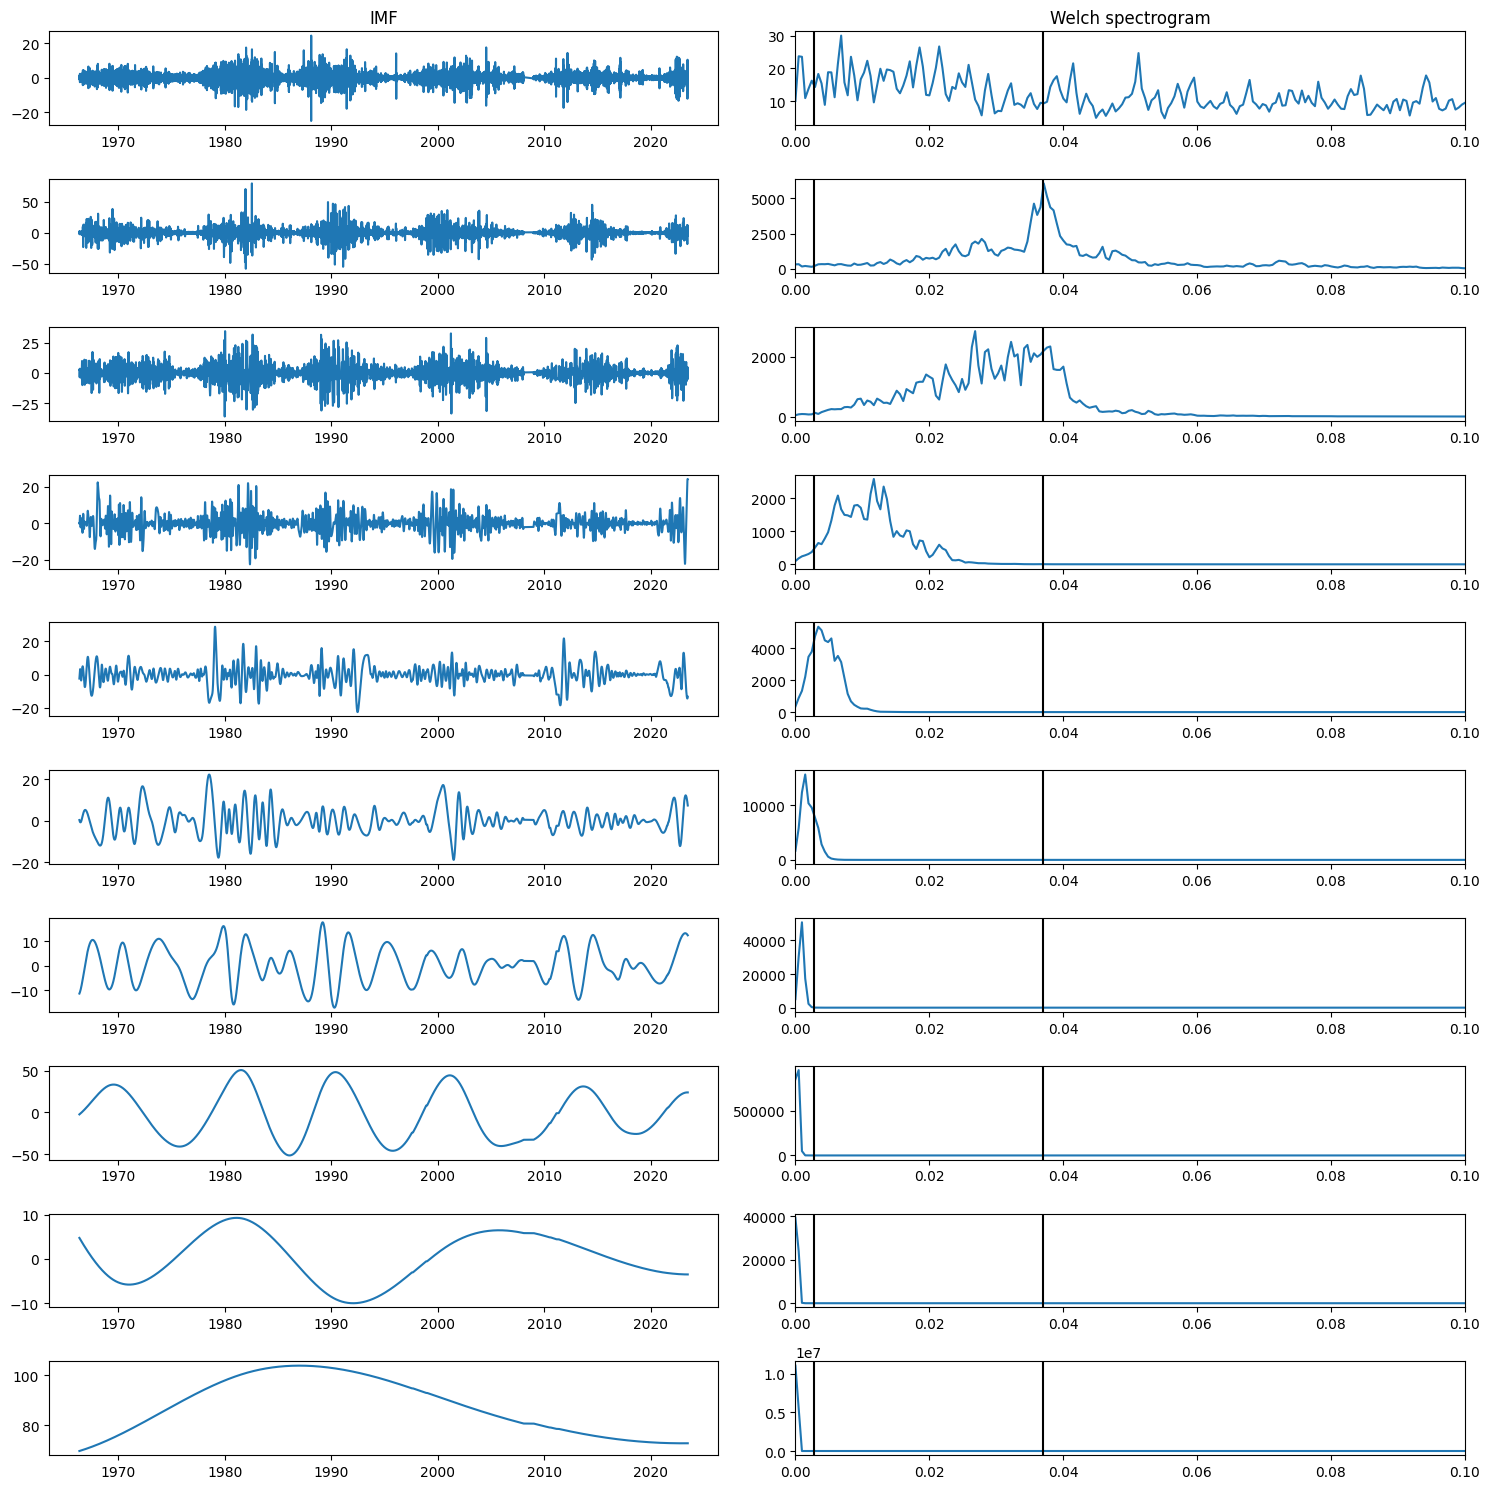

In [550]:
plt.figure(figsize=(15, 15))
for i, vals in enumerate(imf.T):
    plt.subplot(imf.shape[-1], 2, 2 * i + 1)
    if i == 0:
        plt.title('IMF')
    plt.plot(valid_dates, vals)
#     plt.xlim(dt.date(2000, 1, 1), dt.date(2001, 1, 1))
    
    plt.subplot(imf.shape[-1], 2, 2 * i + 2)
    if i == 0:
        plt.title('Welch spectrogram')
    plt.plot(*welch(vals, nperseg=2048, detrend=False))
    plt.xlim(0.0, 0.1)
    plt.axvline(sun_frequency, color='k')
    plt.axvline(1 / 365, color='k')    
plt.tight_layout()

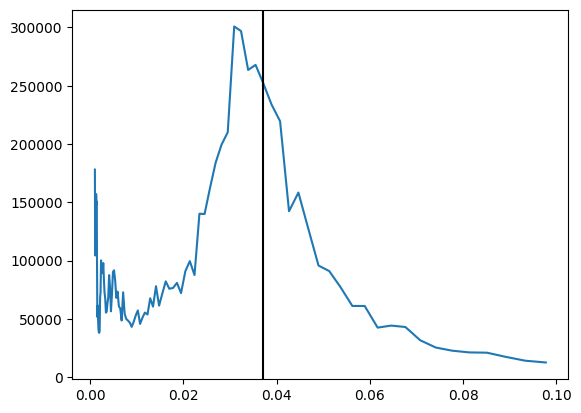

In [551]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 1.0, 'hilbert')
freq_range = (0.001, 0.1, 100, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=True)
plt.plot(f, hht)
plt.axvline(sun_frequency, color='k');